In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import Fragments
from ClickReaction import BocRemoval
from ClickReaction import CuAAC
from rdkit.Chem import  Descriptors
from rdkit.Chem.Draw import IPythonConsole
import io
import itertools
from PIL import Image
from ClickReaction import BocRemoval
from tqdm import tqdm
import re
from rdkit.Chem import Lipinski
from rdkit.Chem import Descriptors
from rdkit.Chem import Crippen

In [15]:
def replace_specific_pattern(text, pattern, replacement):
    return re.sub(pattern, replacement, text)
rxn = Chem.ReactionFromSmarts('[*:6][C:1]#[C:2].[N-:3]=[N+:4]=[N:5]>>[N:5]1([C:2]=[C:1]([*:6])[N:3]=[N:4]1)')

In [16]:
def file_imput(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        file_list = [l.split(',')[-10] for l in lines]
    return file_list

In [17]:
with open ('./BiDe_NH2.csv','r') as f:
    lines = f.readlines()
    amine_smiles = [l.split(',') for l in lines]
amine_smiles = amine_smiles[1:]
amine_smiles_list_1 = []
amine_smiles_list_2 = []
for i in range(len(amine_smiles)):
    molecular = Chem.MolFromSmiles(amine_smiles[i][-10])
    if float(amine_smiles[i][-3])>0.0 and float(amine_smiles[i][-4])>0.0:
        pass
    elif Fragments.fr_hdrzine(molecular)>0:
        pass
    elif float(amine_smiles[i][-4])>1.0:
        amine_smiles_list_2.append([amine_smiles[i][-10],amine_smiles[i][-4]])
    else:
        amine_smiles_list_1.append(amine_smiles[i][-10])

In [18]:
len(amine_smiles_list_1)

15124

In [6]:
with open ('./BiDe_term_acetylene.csv','r') as f:
    lines = f.readlines()
    acetylene_smiles = [l.split(',') for l in lines]
acetylene_smiles = acetylene_smiles[1:]
acetylene_smiles_list_1 = []
acetylene_smiles_list_2 = []
for i in range(len(acetylene_smiles)):
    if float(acetylene_smiles[i][-3]) == 1.0:
        acetylene_smiles_list_1.append(acetylene_smiles[i][-10])
    elif float(acetylene_smiles[i][-3])>1.0:
        acetylene_smiles_list_2.append([acetylene_smiles[i][-10],acetylene_smiles[i][-3]])
    else:
        pass

In [7]:
acetylene_smiles_list_1[1]

'C#CCC(NC(=O)OC(C)(C)C)C(=O)OC'

In [10]:
def convert_primary_amines_to_diazonium(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    primary_amine_pattern = Chem.MolFromSmarts('[NX3;H2]')  
    diazonium_pattern = Chem.MolFromSmiles('[N]=[N+]=[N-]')  
    if molecule.HasSubstructMatch(primary_amine_pattern):
        modified_molecule = Chem.ReplaceSubstructs(molecule, primary_amine_pattern, diazonium_pattern, replaceAll=True)[0]
        new_smiles = Chem.MolToSmiles(modified_molecule, isomericSmiles=True)
        return new_smiles
    elif '[NH2+]' in smiles:
        try:
            boc_protected_amine = Chem.MolFromSmiles(smiles)
            reaction = BocRemoval(bocamine=boc_protected_amine)
            molecule = reaction.get_product()
            modified_molecule = Chem.ReplaceSubstructs(molecule, primary_amine_pattern, diazonium_pattern, replaceAll=True)[0]
            new_smiles = Chem.MolToSmiles(modified_molecule, isomericSmiles=True)
            return new_smiles
        except:
            # print(smiles,"无法脱Boc")
            return None
    else:
        # print( smiles,"未找到一级胺")
        return None

In [11]:
def convert_diazo_to_triaz( acetylene_smiles,amine_smiles):
    rxn = Chem.ReactionFromSmarts('[*:6][C:1]#[C:2].[N-:3]=[N+:4]=[N:5]>>[N:5]1([C:2]=[C:1]([*:6])[N:3]=[N:4]1)')
    try:
        product = rxn.RunReactants((Chem.MolFromSmiles(amine_smiles), Chem.MolFromSmiles(acetylene_smiles)))
        # jb函数要两个括号
        a=Chem.MolToSmiles(product[0][0])
        if '[N+]=[N-]' in a or '[N-]=[N+]' in a:
            a = replace_specific_pattern(a,r'(?<!N=)\[N\+\]=\[N-\]|(?<!\[N\-\]=)\[N-\]=\[N\+\](?!\=N)','N=N')
        return a
    except:
        # print(amine_smiles,acetylene_smiles,"未找到反应产物")
        return None

In [12]:
def smiles_to_image_grid(smiles_list, img_size=(200, 200), mols_per_row=4, kekulize=True):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    if kekulize:
        for mol in mols:
            Chem.Kekulize(mol)
    img = Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=img_size)
    return img

In [2]:
def filter_druglike(mol):
    """
    Filter molecules with druglike rule of 5 in RDKit.
    """
    if Lipinski.NumHDonors(mol) <= 5 and Lipinski.NumHAcceptors(mol) <= 10 and Descriptors.MolWt(mol) <= 500 and Crippen.MolLogP(mol)<=5 and Lipinski.NumRotatableBonds(mol)<=10:
        return True
    else:
        return False

In [23]:
N3_smiles_list = file_imput('./BiDe_N3.csv')
triazole_smiles_list = file_imput('./BiDe_14sub_123triazole.csv')
triazole_smiles_list = triazole_smiles_list[1:]
N3_smiles_list =  N3_smiles_list[1:]

In [26]:
triazole_smiles_list_test=[]
for i in amine_smiles_list_1:
    a=convert_primary_amines_to_diazonium(i)
    N3_smiles_list.append(a)
for i in tqdm(N3_smiles_list):
    for j in acetylene_smiles_list_1:
        b=convert_diazo_to_triaz(i,j)
        triazole_smiles_list_test.append(b)

100%|██████████| 15132/15132 [43:21<00:00,  5.82it/s] 


In [27]:
convert_diazo_to_triaz('C#CCOCCOCCOCCN=[N+]=[N-]','C#CCC(NC(=O)OC(C)(C)C)C(=O)OC')

'C#CCOCCOCCOCCN1C=C(CC(NC(=O)OC(C)(C)C)C(=O)OC)N=N1'

In [28]:
rxn = Chem.ReactionFromSmarts('[*:6][C:1]#[C:2].[N-:3]=[N+:4]=[N:5]>>[N:5]1([C:2]=[C:1]([*:6])[N:3]=[N:4]1)')
polyamines_ex_acetylene = []
for i in tqdm(amine_smiles_list_2):
    for j in acetylene_smiles_list_1:
        k = int(float(i[1]))
        a = convert_primary_amines_to_diazonium(i[0])
        while k>0:
            a = convert_diazo_to_triaz(a,j[0])
            k = k-1
        polyamines_ex_acetylene.append(a)


100%|██████████| 1499/1499 [08:33<00:00,  2.92it/s]


In [29]:
polyyne_equa_amine = []
for i in tqdm(acetylene_smiles_list_2):
    k = int(float(i[1]))
    for j in amine_smiles_list_1:
        j = convert_primary_amines_to_diazonium(j)
        product = rxn.RunReactants((Chem.MolFromSmiles(i[0]), Chem.MolFromSmiles(j)))
        for l in range(k):
            a=Chem.MolToSmiles(product[l][0])
            a = replace_specific_pattern(a,r'(?<!N=)\[N\+\]=\[N-\]|(?<!\[N\-\]=)\[N-\]=\[N\+\](?!\=N)','N=N')
            if a not in polyyne_equa_amine:
                polyyne_equa_amine.append(a)
            else:
                continue

100%|██████████| 48/48 [4:41:26<00:00, 351.79s/it]  


In [35]:
polyyne_ex_amine = []
for i in tqdm(acetylene_smiles_list_2):
    k = int(float(i[1]))
    for j in amine_smiles_list_1:
        j = convert_primary_amines_to_diazonium(j)
        product=Chem.MolFromSmiles(i[0])
        for l in range(k):
            product = rxn.RunReactants((product, Chem.MolFromSmiles(j)))
            product = product[0][0]
        product = Chem.MolToSmiles(product)
        product = replace_specific_pattern(product,r'(?<!N=)\[N\+\]=\[N-\]|(?<!\[N\-\]=)\[N-\]=\[N\+\](?!\=N)','N=N')
        polyyne_ex_amine.append(product)

100%|██████████| 48/48 [09:41<00:00, 12.12s/it]


In [36]:
for i in triazole_smiles_list:
    triazole_smiles_list_test.append(i)
triazole_list = triazole_smiles_list_test

In [37]:
len(triazole_list)

9608879

In [40]:
import csv
def save_list_to_csv(filename, data_list):
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        for item in data_list:
            csv_writer.writerow([item])

save_list_to_csv('triazole_list.csv', triazole_list)


In [42]:
# save_list_to_csv('polyyne_ex_amine.csv', polyyne_ex_amine)
# save_list_to_csv('polyyne_equa_amine.csv', polyyne_equa_amine)
# save_list_to_csv('polyamines_ex_acetylene.csv', polyamines_ex_acetylene)

In [1]:
with open ('./triazole_list.csv', 'r') as f:
    lines = f.readlines()
    triazole_smiles = [l.split('\n')[0] for l in lines]

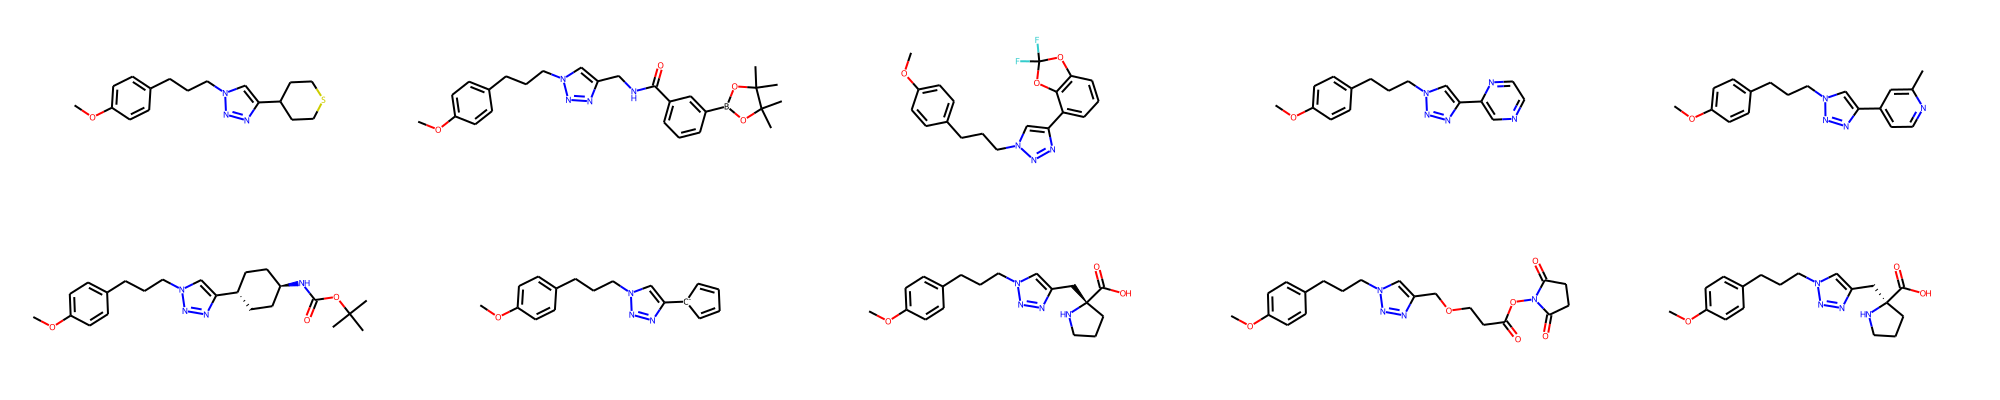

In [43]:
smiles_to_image_grid(druglike_triazole_list[50000:50010], img_size=(400, 200), mols_per_row=5, kekulize=True)


In [51]:
filter_druglike(Chem.MolFromSmiles('NCC(=O)NCC(F)(F)F'))

True

In [5]:
druglike_triazole_list=[]
for i in tqdm(triazole_smiles):
    drug = filter_druglike(Chem.MolFromSmiles(i))
    if drug == True:
        druglike_triazole_list.append(i)
    else:
        continue

100%|██████████| 9608879/9608879 [55:49<00:00, 2868.52it/s]  


In [6]:
len(druglike_triazole_list)


6817649

In [ ]:
save_list_to_csv('druglike_triazole_list.csv', druglike_triazole_list)


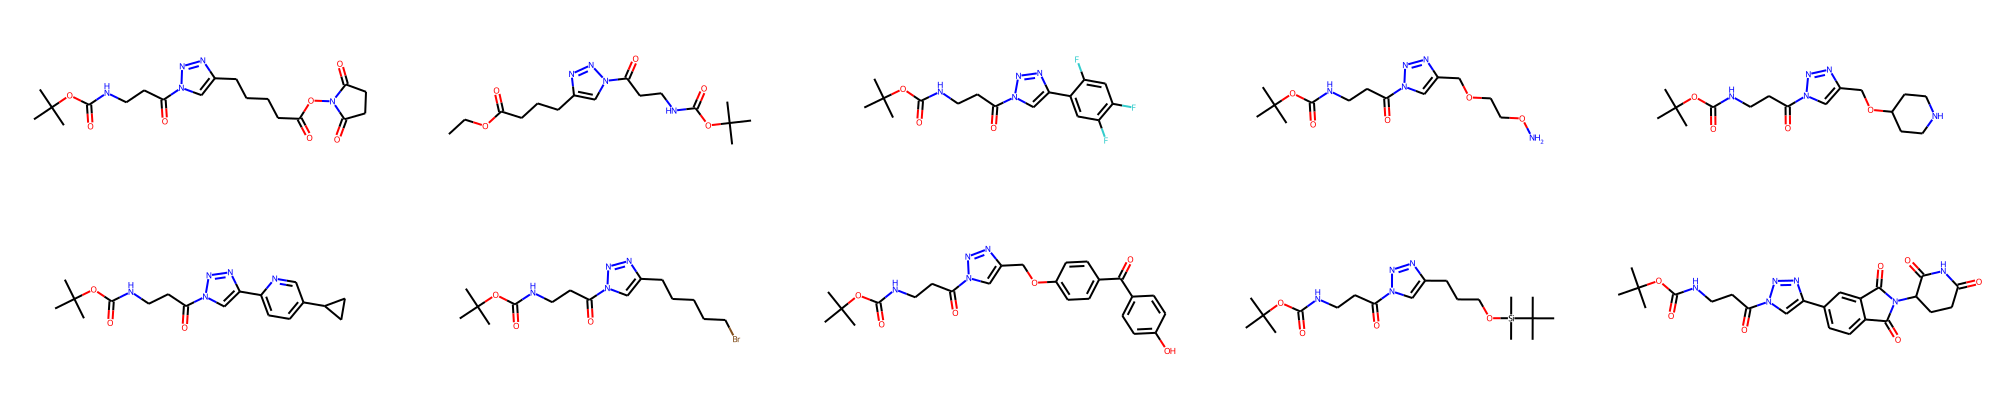

In [56]:
smiles_to_image_grid(druglike_triazole_list[50000:50010], img_size=(400, 200), mols_per_row=5, kekulize=True)

In [13]:
Fragments.fr_NH2(Chem.MolFromSmiles('NCCCCCCCCC(=O)NCO'))

1

In [ ]:
for i in amine_smiles_list_1:
    if Fragments.fr_amide(Chem.MolFromSmiles(i)) == 1 and Fragments.fr_NH2(Chem.MolFromSmiles(i)) == 1:
        print(i)